## Thalamic scRNAseq
Notebook to explore thalamic scRNAseq data, with the ultimate goal of developing a gene panel to distinguish between projection types within thalamus

In [1]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import scipy.io
import scipy.sparse
import matplotlib.pyplot as plt

In [2]:
# Function to create volcano plots
def plotVolcano(dataObj, indx = 0, thresh = 10, label = ["top"]):
    """ Create a volcano plot for given log fold changes and p values. Takes annData 
    object with "rank_gene_groups" field as input. Indx denotes group to look at.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Clean inputs, check that label is a list rather than string
    if type(label) == str:
        label = [label]
    
    # Get class names
    rankGenes = dataObj.uns["rank_genes_groups"]
    groups = rankGenes["names"].dtype.names
    
    # If indx is an int, find appropriate string conversion
    if type(indx) == int:
        indx = groups[indx]
    
    rankGenes = dataObj.uns["rank_genes_groups"]
    groups = rankGenes["names"].dtype.names
    pVal = rankGenes["pvals_adj"][indx] #pvals_adj
    logFoldChange = rankGenes["logfoldchanges"][indx]

    # Adjust unplottable
    pVal[pVal == 0] = min(pVal[pVal > 0])
    pVal = -np.log10(pVal)
    # Determine how to color points
    upExpressed = (logFoldChange > 3) & (pVal > thresh)
    downExpressed = (logFoldChange < -3) & (pVal > thresh)
    belowThresh = ~(upExpressed | downExpressed)
    
    # Plot genes that fall above and below baseline
    fig = plt.subplots()
    plt.grid(True, which = "both")
    plt.plot(logFoldChange[belowThresh], pVal[belowThresh], '.', color='gray', markersize = 2)
    plt.plot(logFoldChange[upExpressed], pVal[upExpressed], '.', color='green', markersize = 2)
    plt.plot(logFoldChange[downExpressed], pVal[downExpressed], '.', color='blue', markersize = 2)
    plt.xlabel("Log2 Fold Change")
    plt.ylabel("- Log10 ( pVal ) ")
    
    # Check for annotation requests. Default behavior is to annotate the top X genes, otherwise plot requested genes
    if label == ["top"]:
        for i in [0]:
            plt.annotate(rankGenes["names"][indx][i], [logFoldChange[i],pVal[i]])
            plt.annotate(rankGenes["names"][indx][-(i + 1)], [logFoldChange[-(i + 1)],pVal[-(i + 1)]])
    else:
        for i in range(len(label)):
            geneIndx = rankGenes["names"][indx].tolist().index(label[i])
            plt.annotate(label[i], [logFoldChange[geneIndx], pVal[geneIndx]])
    plt.title(indx + ' vs ' + rankGenes["params"]["reference"] + ' reference')
    return fig
    
# function to create a mask dictionary for umap plotting
def create_mask_dict(names,show_name):
    mask_dict = {}
    for name in names:
        if str(name) == show_name:
            mask_dict[name] = "red"
        else:
            mask_dict[name] = "lightgray"
    return mask_dict

In [2]:
# Load in pre-processed data
thData = sc.read("../Data/thData.h5ad")

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
# Check dimensions of data / processing that has already been done
thData

AnnData object with n_obs × n_vars = 66800 × 23431
    obs: 'sample_id', 'umi_counts', 'gene_counts', 'sex', 'facs', 'roi', 'roi_label', 'roi_color', 'cl', 'cluster_id', 'cluster_label', 'cluster_color', 'subclass_id', 'subclass_label', 'subclass_color', 'class_id', 'class_label', 'class_color', 'forebrain_cluster_label', 'forebrain_subclass_label', 'forebrain_neighborhood_label', 'qc'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cl_colors', 'class_id_colors', 'class_label_colors', 'cluster_id_colors', 'hvg', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [51]:
# plt.rcParams['font.size'] = 10
plt.rcParams['font.size'] = 16

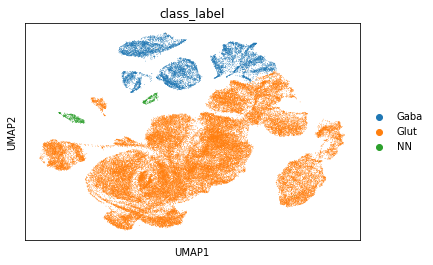

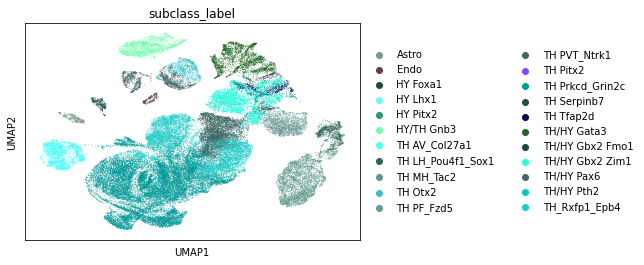

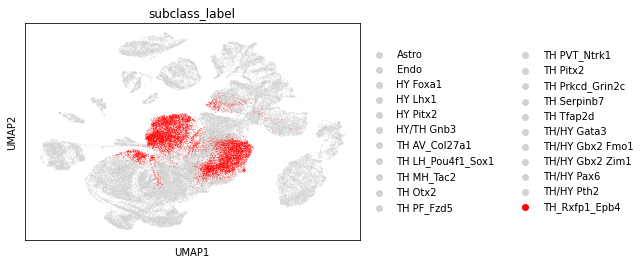

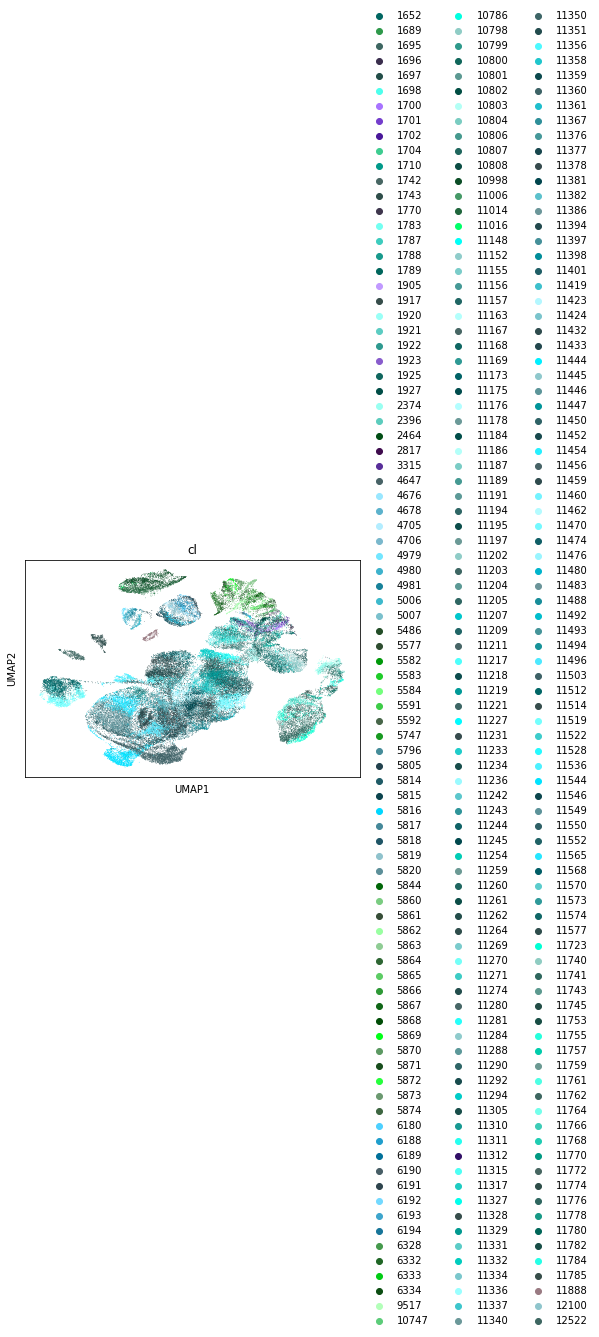

In [7]:
# Plot class UMAPs, comparing subclass and class labels
sc.pl.umap(thData, color="class_label")

# Plot subclass umap, using subclass colors
color_dict = dict(zip(thData.obs["subclass_label"],thData.obs["subclass_color"]))
sc.pl.umap(thData, color="subclass_label",palette =color_dict)

# Emphasize a particular cluster with masked plotting
maskPalette = create_mask_dict(thData.obs.subclass_label.unique(),"TH_Rxfp1_Epb4")
sc.pl.embedding(thData, "umap", color = "subclass_label", palette=maskPalette)

# Plot cluster umap, using cluster colors
color_dict = dict(zip(thData.obs["cl"],thData.obs["cluster_color"]))
sc.pl.umap(thData, color="cl",palette =color_dict)

## Class Analysis
Look at differences between broad classes (glutamatergic, gabaergic, non-neuronal). To some degree this is "proof of concept" analysis: should feel reasonably good about these cluster distinctions

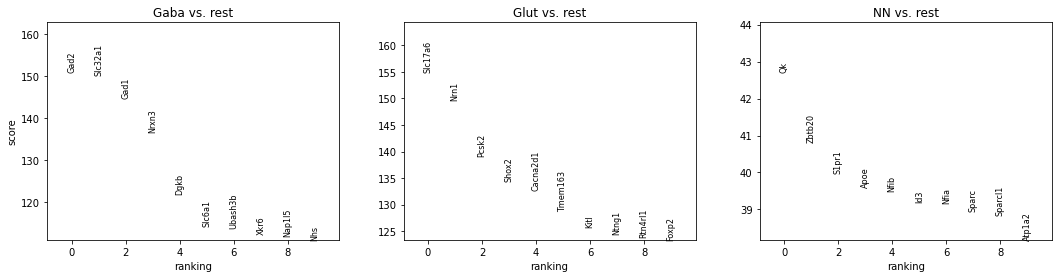

In [87]:
# Rank class genes. There are two potential ways to do this:

# The first is comparing genes in a group to all other cell
sc.tl.rank_genes_groups(thData, 'class_label', method='wilcoxon')
sc.pl.rank_genes_groups(thData, n_genes=10, sharey=False)

# The second is to compare cells to a specific reference cluster, in this case gabaergic neurons
# sc.tl.rank_genes_groups(thData, 'class_label', method='wilcoxon', groups=['Glut'], reference='Gaba', pts=True)
# sc.pl.rank_genes_groups(thData, n_genes=10, sharey=False)

In [274]:
# Examine fields within the "rank_genes_group" structure
thData.uns["rank_genes_groups"]

{'params': {'groupby': 'class_label',
  'reference': 'Gaba',
  'method': 'wilcoxon',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'pts':                     Glut      Gaba
 gene                              
 Xkr4            0.997959  0.999772
 Rp1             0.048663  0.026283
 Sox17           0.000610  0.000569
 Mrpl15          0.527968  0.450222
 Lypla1          0.008547  0.003982
 ...                  ...       ...
 AC168977.1      0.002808  0.001252
 AC149090.1      0.982942  0.976675
 CAAA01118383.1  0.265676  0.228240
 Vmn2r122        0.000157  0.000000
 CAAA01147332.1  0.002860  0.002162
 
 [23431 rows x 2 columns],
 'names': rec.array([('Slc17a6',), ('Nrn1',), ('Pcsk2',), ..., ('Gad1',),
            ('Slc32a1',), ('Gad2',)],
           dtype=[('Glut', 'O')]),
 'scores': rec.array([( 150.54643,), ( 146.21182,), ( 135.1744 ,), ...,
            (-144.84816,), (-150.07939,), (-150.68303,)],
           dtype=[('Glut', '<f4')]),
 'pvals': rec.array(

In [46]:
# Print out a dataframe with differentially expressed genes ranked by z score
rankGenes = thData.uns["rank_genes_groups"]
groups = rankGenes["names"].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: rankGenes[key][group]
    for group in groups for key in ['names', 'pvals', 'scores', 'logfoldchanges']})

Glut_n  Glut_p      Glut_s     Glut_l
0       Slc17a6     0.0  150.546432  12.413570
1          Nrn1     0.0  146.211823  12.410526
2         Pcsk2     0.0  135.174393   6.136325
3      Cacna2d1     0.0  130.621933   8.359766
4         Shox2     0.0  129.967804   9.191735
...         ...     ...         ...        ...
23426      Dgkb     0.0 -122.486847  -4.307752
23427     Nrxn3     0.0 -136.604187  -4.715155
23428      Gad1     0.0 -144.848160 -14.066273
23429   Slc32a1     0.0 -150.079391 -15.609193
23430      Gad2     0.0 -150.683029 -15.326777

[23431 rows x 4 columns]

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise != comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.
  if s != self._text:


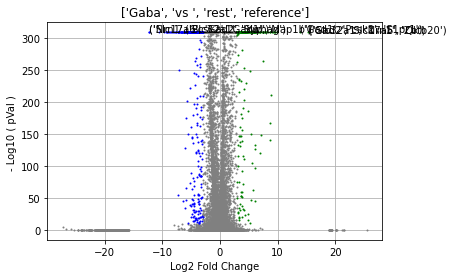

In [88]:
# Plot differential expression for all genes in a volcano plot, and for specific genes in violin plots
plotVolcano(thData)

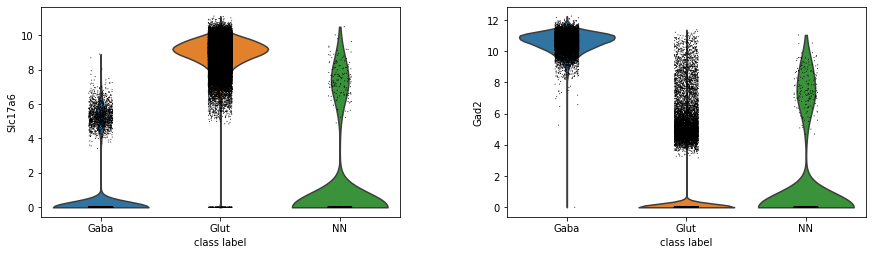

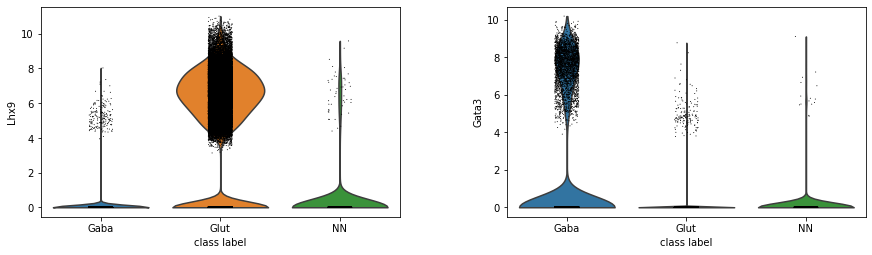

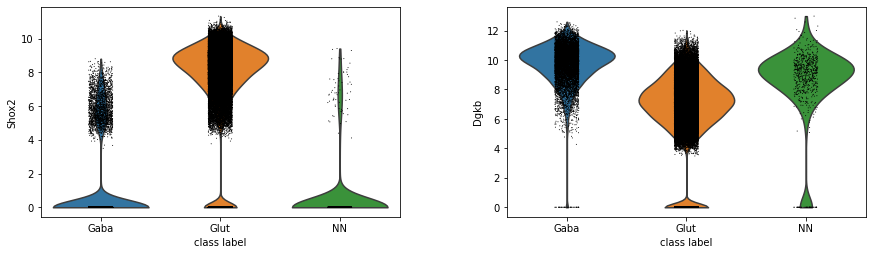

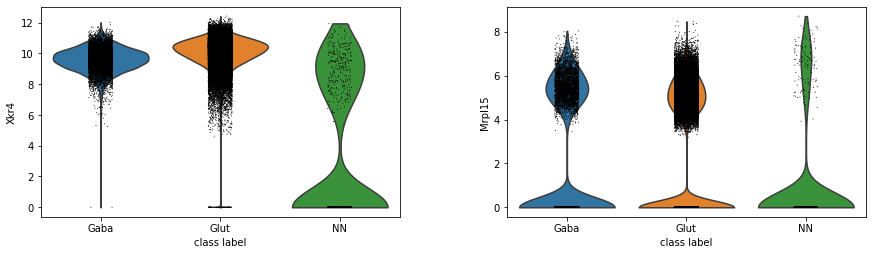

In [44]:
# Most upregulated gene Slc17a6 (A.K.A. VGlut2) is most upregulated gene, and Gad2 is most downregulated 
# gene when Glut cluster is compared to Gaba cluster
sc.pl.violin(thData,[ "Slc17a6", "Gad2"], groupby="class_label")

# 5th most upregulated gene "Shox2" and 5th most downregulated gene "Dgkb" (by Wilcoxon) [ for logistic, try Lhx9 and Gata3]
sc.pl.violin(thData,[ "Lhx9", "Gata3"], groupby="class_label")
sc.pl.violin(thData,[ "Shox2", "Dgkb"], groupby="class_label")

# Two genes which should have approximately similar expression patterns
sc.pl.violin(thData,[ "Xkr4", "Mrpl15"], groupby="class_label")

In [90]:
# Look at marker gene overlap
markerGenes = {
    'GABA Cells' : {"Gad2","Dgkb", "Nrxn3"},
    'Glut Cells' : {"Slc17a6", "Nrn1", "Cacna2d1", "Shox2", "Pcsk2"},
    'Other' : {"Xkr4"}
}
markerOverlap = sc.tl.marker_gene_overlap(thData,markerGenes,method="jaccard", top_n_markers=5, inplace=False)
markerOverlap

Gaba  Glut   NN
GABA Cells   0.6   0.0  0.0
Glut Cells   0.0   1.0  0.0
Other        0.0   0.0  0.0

In [84]:
thData.uns["rank_genes_groups"]["names"]

rec.array([('Slc17a6',), ('Nrn1',), ('Pcsk2',), ..., ('Gad1',),
           ('Slc32a1',), ('Gad2',)],
          dtype=[('Glut', 'O')])

## Subclass analysis
Compare differential expression between more granular groups, subclass clusters

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399

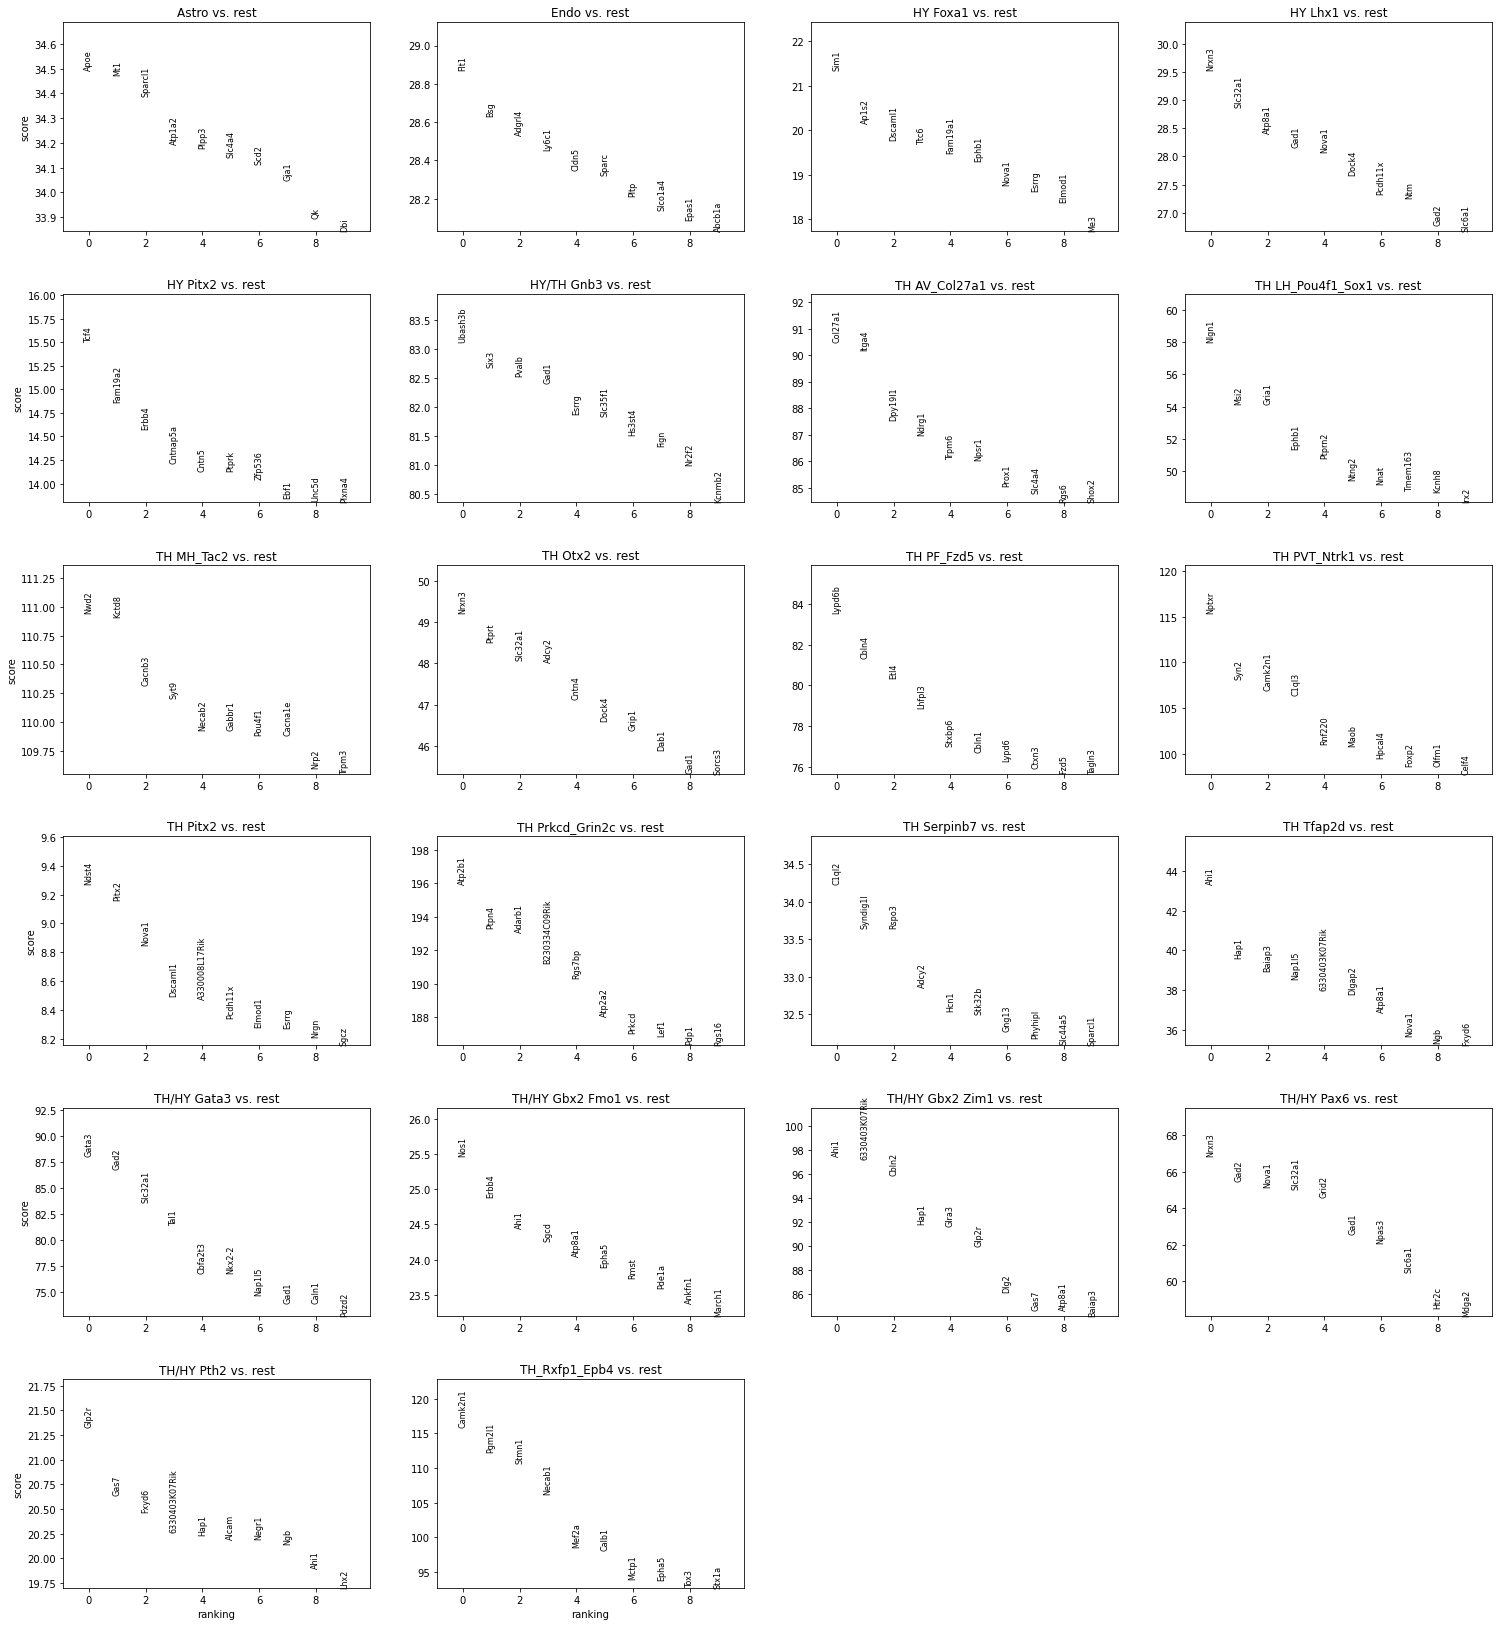

In [4]:
# Rank differentially expressed genes by comparing subclasses to all other subclass clusters
sc.tl.rank_genes_groups(thData, 'subclass_label', method='wilcoxon',pts=True)
sc.pl.rank_genes_groups(thData, n_genes=10, sharey=False)

In [113]:
thData

AnnData object with n_obs × n_vars = 66800 × 23431
    obs: 'sample_id', 'umi_counts', 'gene_counts', 'sex', 'facs', 'roi', 'roi_label', 'roi_color', 'cl', 'cluster_id', 'cluster_label', 'cluster_color', 'subclass_id', 'subclass_label', 'subclass_color', 'class_id', 'class_label', 'class_color', 'forebrain_cluster_label', 'forebrain_subclass_label', 'forebrain_neighborhood_label', 'qc'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cl_colors', 'class_id_colors', 'class_label_colors', 'cluster_id_colors', 'hvg', 'neighbors', 'umap', 'rank_genes_groups', 'subclass_label_colors', 'cluster_label_colors', 'subclass_color_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [26]:
# Print out a dataframe with differentially expressed genes ranked by z score
rankGenes = thData.uns["rank_genes_groups"]
groups = rankGenes["names"].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: rankGenes[key][group]
    for group in groups for key in ['names', 'pvals', 'scores', 'logfoldchanges']})

Astro_n        Astro_p    Astro_s    Astro_l  Endo_n         Endo_p  \
0         Apoe  1.003056e-260  34.493526  18.665472    Flt1  2.851825e-183   
1          Mt1  2.045695e-260  34.472878  12.911304     Bsg  2.669253e-180   
2      Sparcl1  3.390138e-259  34.391399  10.730921  Adgrl4  4.568669e-179   
3       Atp1a2  2.805279e-256  34.195660  17.145878   Ly6c1  4.392484e-178   
4        Plpp3  4.720561e-256  34.180450  14.251336   Cldn5  8.431749e-177   
...        ...            ...        ...        ...     ...            ...   
23426   Anks1b  1.719582e-257 -34.277142  -9.903663     Syp  7.818930e-133   
23427   Snhg11  9.205616e-258 -34.295349 -11.204991  Mllt11  4.021173e-134   
23428    Rims1  1.435461e-258 -34.349445 -13.731631   Syt11  8.169116e-135   
23429     Nrg3  1.970212e-259 -34.407166 -14.498149   Vamp2  4.693634e-138   
23430     Meg3  1.544825e-260 -34.481014 -11.084251   Ywhag  2.717385e-141   

          Endo_s     Endo_l     HY Foxa1_n     HY Foxa1_p  ...  TH/HY Pax6_s  \
0      28.869892  18.225510           Sim1  4.153095e-101  ...     66.861755   
1      28.632219   5.507307          Ap1s2   2.067271e-90  ...     65.485405   
2      28.532978  16.345148        Dscaml1   4.182380e-87  ...     65.165230   
3      28.453646  18.787481           Ttc6   2.077032e-86  ...     65.019669   
4      28.349741  19.000990        Fam19a1   1.566696e-84  ...     64.581680   
...          ...        ...            ...            ...  ...           ...   
23426 -24.525908  -4.765698          Auts2   1.265383e-71  ...    -61.389187   
23427 -24.646410  -7.190888          Ildr2   9.565238e-72  ...    -62.130745   
23428 -24.710886  -4.891648  1810041L15Rik   6.484511e-73  ...    -64.994331   
23429 -25.010551  -6.096020           Kitl   2.582836e-76  ...    -66.605362   
23430 -25.306379  -4.628901         Tcf7l2   7.912145e-92  ...    -69.714912   

       TH/HY Pax6_l   TH/HY Pth2_n   TH/HY Pth2_p  TH/HY Pth2_s  TH/HY Pth2_l  \
0          4.500290          Glp2r  6.146555e-101     21.328720      8.325873   
1         12.831064           Gas7   1.275861e-94     20.637062      8.027392   
2          6.465590          Fxyd6   3.658257e-93     20.474184      8.502295   
3         10.895026  6330403K07Rik   2.670172e-91     20.264059      6.515890   
4          4.088473           Hap1   4.914553e-91     20.234003      5.376988   
...             ...            ...            ...           ...           ...   
23426    -10.126359  1700020I14Rik   1.728197e-78    -18.756035     -4.879304   
23427     -9.409252          Ntng1   1.812978e-80    -18.996790    -11.491431   
23428    -11.495311           Zic1   1.419946e-80    -19.009613     -9.525897   
23429    -11.158021           Thy1   1.036571e-87    -19.853077     -5.729316   
23430    -12.275301          Hdac9   3.342453e-88    -19.909861     -7.299996   

      TH_Rxfp1_Epb4_n  TH_Rxfp1_Epb4_p  TH_Rxfp1_Epb4_s  TH_Rxfp1_Epb4_l  
0             Camk2n1              0.0       115.889664         2.291392  
1              Pgm2l1              0.0       112.313774         1.957252  
2               Stmn1              0.0       110.656517         2.860398  
3              Necab1              0.0       106.265045         6.581824  
4               Mef2a              0.0        98.550713         1.587399  
...               ...              ...              ...              ...  
23426            Msi2              0.0       -72.699402        -1.674492  
23427           Nrxn3              0.0       -73.207291        -1.540399  
23428           Cplx1              0.0       -74.108032        -2.488528  
23429         Slc24a2              0.0       -79.167282        -2.034312  
23430            Sox5              0.0       -83.853340        -5.688861  

[23431 rows x 88 columns]

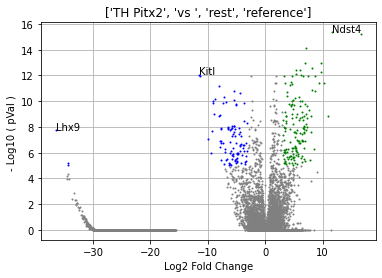

In [51]:
# Plot differential expression for all genes in a volcano plot, and for specific genes in violin plots
plotVolcano(thData,12, 5)

In [28]:
# Find maximal logfold change gene for a particular subclass
x = pd.DataFrame(
        {group + '_' + key[:1]: rankGenes[key][group]
        for group in groups for key in ['names', 'pvals', 'scores', 'logfoldchanges']})
y = x["TH Pitx2_l"]
x["TH Pitx2_n"][y.idxmin()]


'Lhx9'

In [186]:
# Sort by logfoldchange
x = pd.DataFrame(
        {group + '_' + key[:1]: rankGenes[key][group]
        for group in groups for key in ['names', 'pvals', 'scores', 'logfoldchanges']})
x = x.sort_values(by="TH PVT_Ntrk1_l", ascending=False)
indx = 11
print(x.iloc[45:60,(indx*4):(indx*4+4)])

      TH PVT_Ntrk1_n  TH PVT_Ntrk1_p  TH PVT_Ntrk1_s  TH PVT_Ntrk1_l
10899       Igkv6-29    9.820059e-01        0.022554       19.518236
10902  4930434O05Rik    9.820059e-01        0.022554       19.483196
10916          Esp34    9.820059e-01        0.022554       19.472939
3              C1ql3    0.000000e+00      106.446716       10.528555
5               Maob    0.000000e+00      100.874496        8.068742
8621          Sprr1a    6.533622e-01        0.449096        8.035760
2642          Sprr2i    4.125015e-37       12.728149        7.765748
23           Cntnap3    0.000000e+00       91.395798        7.493050
13             Calb2    0.000000e+00       94.953720        7.457263
39             Rab3b    0.000000e+00       85.741051        7.434725
8880           Foxi1    7.366323e-01        0.336316        7.328486
44            Necab1    0.000000e+00       84.613480        6.964807
62             Sulf1    0.000000e+00       79.222389        6.960006
0              Nptxr    0.000000e+

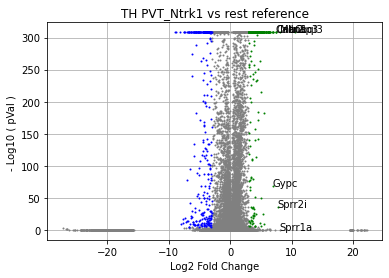

In [185]:
indx = 11
fig = plotVolcano(thData,indx, 5, ["C1ql3", "Maob", "Sprr2i", "Sprr1a", "Calb2", "Cntnap3", "Gypc"])
# plt.savefig("../Figures/Panels/" + thData.uns["rank_genes_groups"]["names"].dtype.names[indx] + ".png")

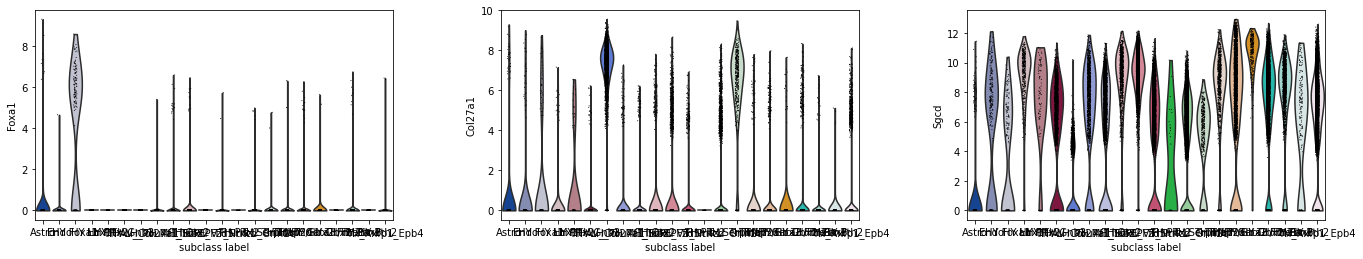

In [30]:
sc.pl.violin(thData,["Foxa1", "Col27a1", "Sgcd"], groupby="subclass_label")

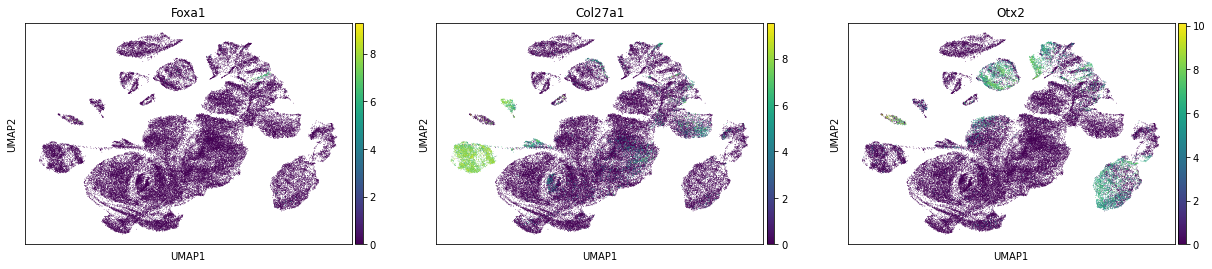

In [28]:
sc.pl.umap(thData, color = ["Foxa1", "Col27a1", "Otx2"])

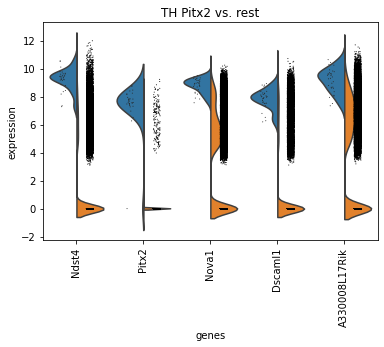

In [24]:
sc.pl.rank_genes_groups_violin(thData, groups="TH Pitx2", n_genes=5)

In [ ]:
# Save thData w/ rank_gene_groups structure, if desired
fnResults = "../Data/thData.h5ad"
thData.write(fnResults)

## Glutamatergic neuron specific analysis

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


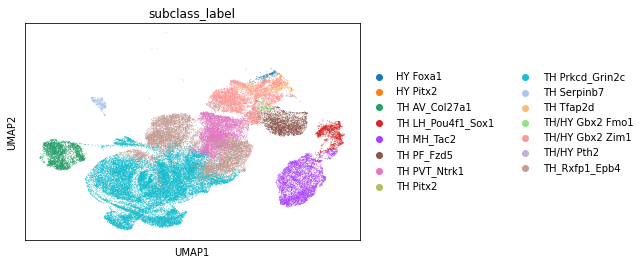

In [4]:
# Index by cell class
gluData = thData[thData.obs.class_label == "Glut"]
sc.pl.umap(gluData, color="subclass_label")

In [5]:
# Dispense the number of cells within each subclass
gluTypes = gluData.obs.subclass_label.unique()
pd.DataFrame([sum(gluData.obs.subclass_label == name) for name in gluTypes], index = gluTypes)

0
TH/HY Gbx2 Zim1     5006
TH/HY Pth2           170
TH Tfap2d            774
TH LH_Pou4f1_Sox1   1346
TH Pitx2              30
TH PF_Fzd5          2500
TH_Rxfp1_Epb4      10411
TH Prkcd_Grin2c    23362
TH PVT_Ntrk1        5419
TH AV_Col27a1       3011
TH MH_Tac2          4405
TH/HY Gbx2 Fmo1      248
TH Serpinb7          398
HY Foxa1             170
HY Pitx2              83

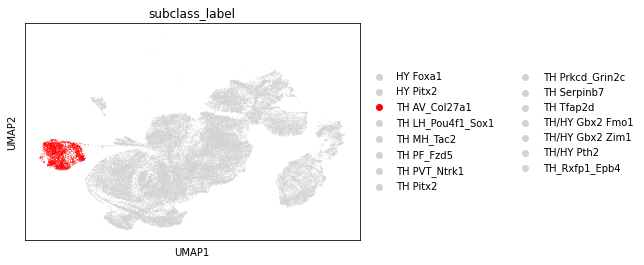

In [8]:
# Plot masked embedding, where all but one group is filtered out
indx = "TH AV_Col27a1"
maskPalette = create_mask_dict(gluTypes,indx)
fig = sc.pl.embedding(gluData, "umap", color = "subclass_label", palette=maskPalette, show=False)
plt.savefig("../Figures/Panels/" + indx + " UMAP.png")

TypeError: 'Axes' object is not subscriptable

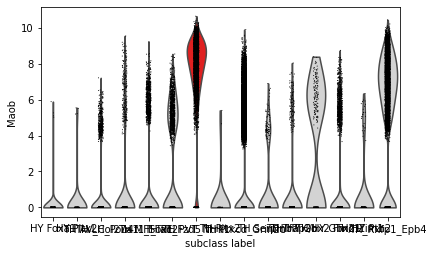

In [224]:
fig = sc.pl.violin(gluData,[ "Maob"], groupby="subclass_label", show=False)
fig.

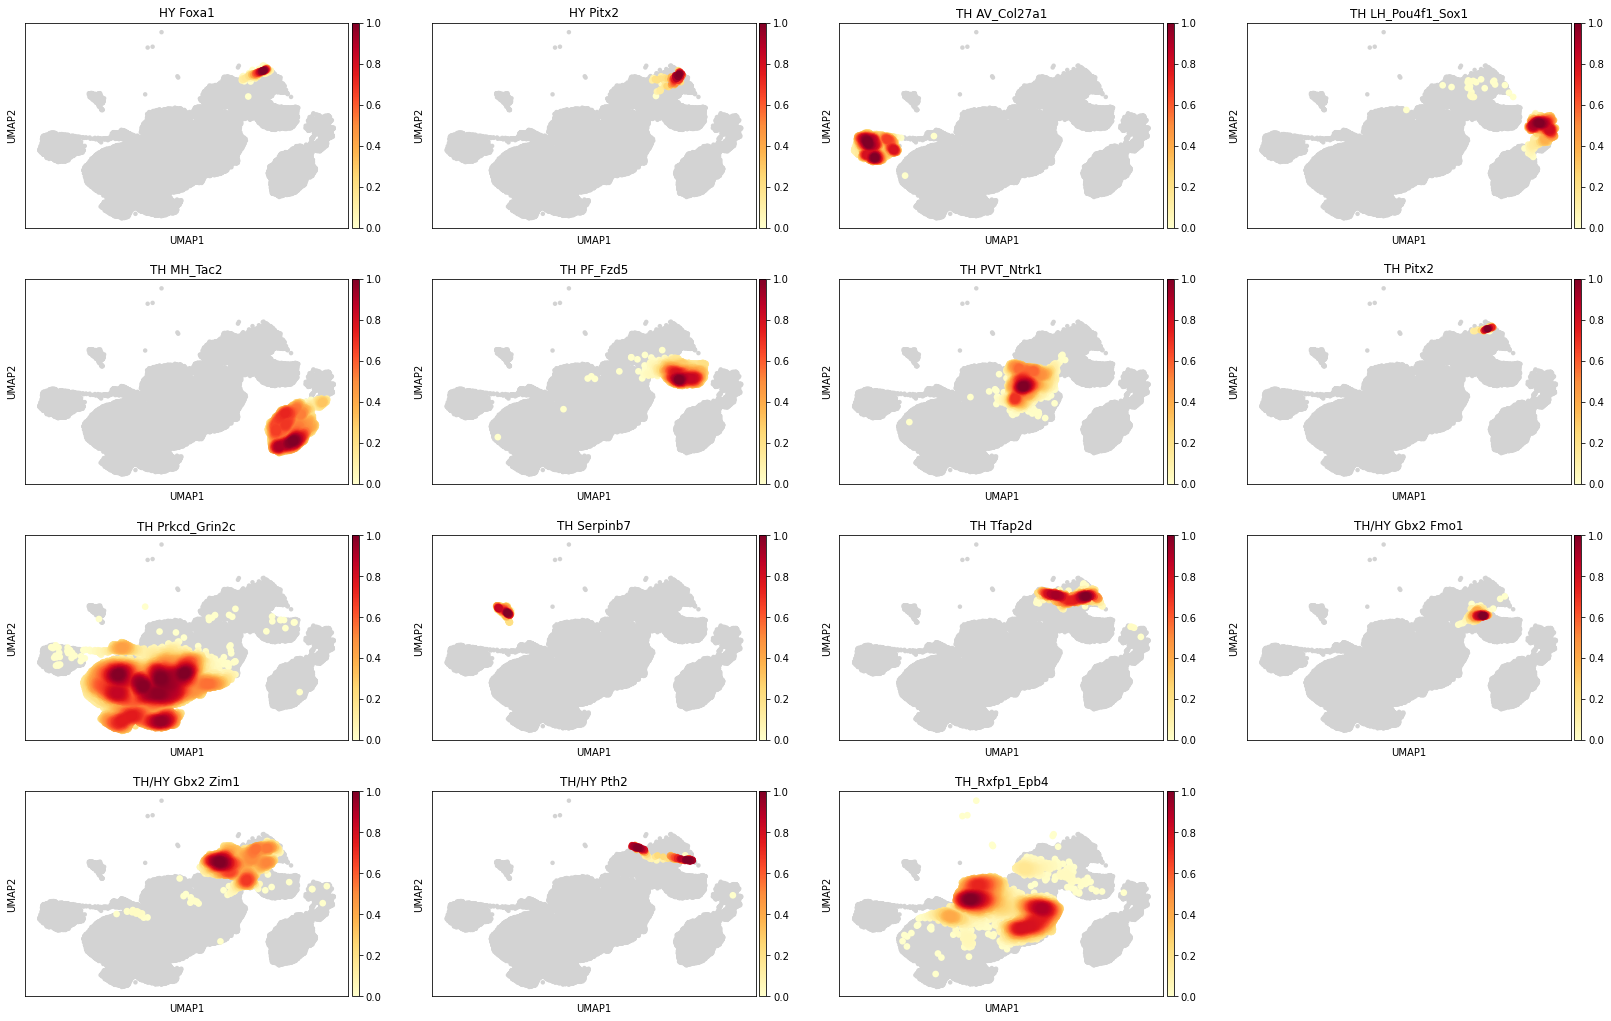

In [232]:
sc.tl.embedding_density(gluData, basis="umap",groupby="subclass_label")
sc.pl.embedding_density(gluData, basis="umap", key="umap_density_subclass_label")

## Cluster specific analysis
Looking at clusters specifically within the "Glut" group

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: Perf

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:409: Perform

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: P

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: Perf

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: Perf

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: Perfo

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: Perfo

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: Perf

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: Perf

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:409: Perform

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: Perfo

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: P

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: P

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: Perfo

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: P

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: Perf

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: P

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: Perfo

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: Perfo

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: Perfo

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: Perfo

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:409: Perform

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: Perfo

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: Perfo

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: P

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:409: Perform

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:409: Perform

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:409: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: P

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals'] = pvals[global_indices]
C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\scanpy\tools\_rank_genes_groups.py:409: Perform

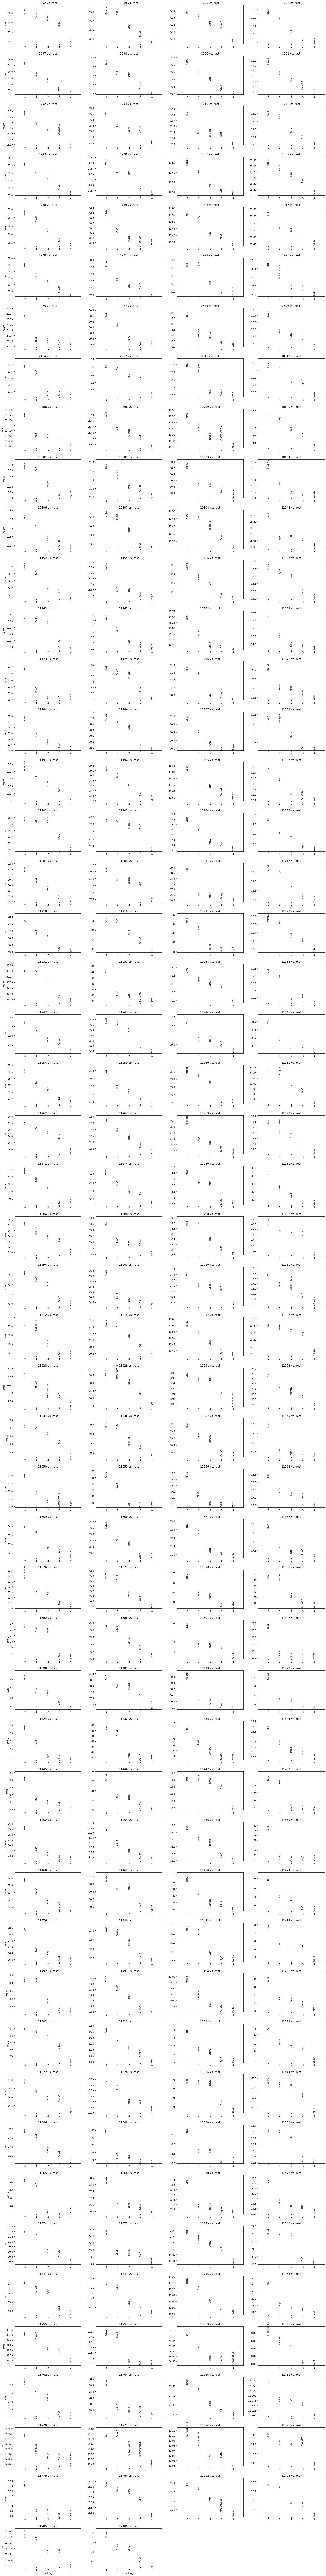

In [6]:
# Rank differentially expressed genes by comparing subclasses to all other subclass clusters
sc.tl.rank_genes_groups(gluData, 'cl', method='wilcoxon',pts=True)
sc.pl.rank_genes_groups(gluData, n_genes=5, sharey=False)

In [8]:
plotVolcano(gluData, '2024')

NameError: name 'plotVolcano' is not defined

In [7]:
# Dispense the number of cells within each subclass
gluTypes = gluData.obs.cluster_id.unique()
x = pd.DataFrame([sum(gluData.obs.cluster_id == name) for name in gluTypes], index = gluTypes)
print(x[0].nlargest(5))
x.index.tolist().index(1965)

2024    3090
2018    2850
2025    2061
1965    1775
2016    1695
Name: 0, dtype: int64


20

In [276]:
rankGenes = gluData.uns["rank_genes_groups"]
groups = rankGenes["names"].dtype.names
rankGenes["names"][0][20]

'Ahi1'

In [24]:
# Save gluData w/ cluster based rank_gene_groups structure, if desired
fnResults = "../Data/clData.h5ad"
gluData.write(fnResults)

## Classification

In [77]:
gluData

View of AnnData object with n_obs × n_vars = 57333 × 23431
    obs: 'sample_id', 'umi_counts', 'gene_counts', 'sex', 'facs', 'roi', 'roi_label', 'roi_color', 'cl', 'cluster_id', 'cluster_label', 'cluster_color', 'subclass_id', 'subclass_label', 'subclass_color', 'class_id', 'class_label', 'class_color', 'forebrain_cluster_label', 'forebrain_subclass_label', 'forebrain_neighborhood_label', 'qc'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cl_colors', 'class_id_colors', 'class_label_colors', 'cluster_id_colors', 'hvg', 'neighbors', 'umap', 'rank_genes_groups', 'subclass_label_colors'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

### To do
Need to quantify the spread / variance of a cluster
Need to quantify classification error

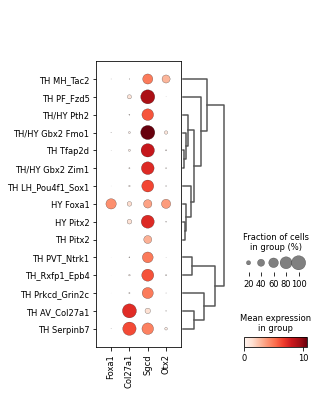

In [9]:
sc.pl.dotplot(gluData,["Foxa1", "Col27a1", "Sgcd","Otx2"],"subclass_label", dendrogram = True)

In [99]:
sc.pl.rank_genes_groups_dotplot(gluData, n_genes=2)

KeyError: 'rank_genes_groups'

### Notes

Things to consider:  
- Do we need Gaba & NN classes?
    - 22 subclasses with, 15 without ( 2/15 are HY annotated )
    - How does inclusion affect MERSCOPE distinguishability?   


- Do we have sufficient resolution of clusters? What does it mean if:
    - p-types > t-types? [need more clusters -> better MERFISH resolution]
    - t-types > p-types? [clusters are oversampled, smaller gene panel might be feasible]  
    
    
Future things to try / think about:
- Adjust UMAP hyperparameters
- Think about ROC analysis
- What is the transformation between scRNAseq / MERFISH?
    - Does each technique resolve differential expression similarly well? 
    - Is the same magnitude of differential expression equally resolvable for low and high baseline genes? If cluster X expresses a transcript at a high level, but all other clusters have a non-zero basal level of expression, is that transcript a useful marker?
    - Is negative differential expression useful for MERFISH?